# Capsule Neural Network (CapsNet) Implementation

Implementation of the paper [Dynamic Routing Between Capsules](https://arxiv.org/pdf/1710.09829.pdf) by Sara Sabour, Nicholas Frosst, and Geoffrey E. Hinton. Used [jindongwang/Pytorch-CapsuleNet](https://github.com/jindongwang/Pytorch-CapsuleNet) and [laubonghaudoi/CapsNet_guide_PyTorch](https://github.com/laubonghaudoi/CapsNet_guide_PyTorch) to clarify some confusions, and borrowed some code.

## Setup PyTorch

In [ ]:
!pip install torch torchvision
!pip install matplotlib
!pip install import-ipynb
!pip install tqdm
!pip install pytorch_extras

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=9c53663bf9e21b7226f45d02822697fc05235700fa1338e4dfa564f18ff20bac
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
  Created wheel for pytorch-extras: filename=pytorch_extras-0.1.3-cp37-none-any.whl size=2833 sha256=eeca9c30935d029abb158c1fed9ec49c06c40eb85ff33da4ef0d86880c9ddb1c
  Stored in directory: /root/.cache/pip/wheels/5b/7c/5a/f27d4088adfe722cb280d523a1ed9eeb33be11b8d3a653292a
Successfully built pytorch-extras


In [ ]:
from google.colab import drive
drive.mount("mnt")

Mounted at mnt


In [ ]:
%cd "mnt/My Drive"

/content/mnt/My Drive


In [ ]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch_extras
import torch.nn as nn
import torchvision.utils as tv_utils
import torch.nn.functional as F
from torch.autograd import Variable
import import_ipynb
import load_DrawData as loader
import numpy as np
import argparse
from tqdm import tqdm
%matplotlib inline
# %mkdir -p /content/project/
# %cd /content/project/

importing Jupyter notebook from load_DrawData.ipynb
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=e7e53d7c1a347852b562640a14204e0da6c772869bce5d1d6a2262eed4535b25
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi
4200
2800
total training samples: 4200
total validatoin samples: 1400
total test samples: 1400
mkdir: cannot create directory ‘quickDrawData’: File exists
gs://quickdraw_dataset/full/simplified/t-shirt.ndjson
Copying gs://quickdraw_dataset/full/simplified/t-shirt.ndjson...
\ [1/1 files][ 41.3 MiB/ 41.3 MiB] 100% Done                                    
Operation completed over 1 objects/41.3 MiB.                                     
gs://quickdraw_dataset/full/simplified/rabbit.ndjson
Copying gs://quickdraw_dataset/full/simplified/rabbit.ndjson...
| [1/1 files][ 95.0 MiB/ 95.0 MiB] 100% Done   

## CapsNet Modules

In [ ]:
class PrimaryCapsules(nn.Module):
    '''
    The `PrimaryCaps` layer consists of 32 capsule units. Each unit takes
    the output of the `Conv1` layer, which is a `[256, 20, 20]` feature
    tensor (omitting `batch_size`), and performs a 2D convolution with 8
    output channels, kernel size 9 and stride 2, thus outputing a [8, 6, 6]
    tensor. In other words, you can see these 32 capsules as 32 paralleled 2D
    convolutional layers. Then we concatenate these 32 capsules' outputs and
    flatten them into a tensor of size `[1152, 8]`, representing 1152 8D
    vectors, and send it to the next layer `DigitCaps`.
    As indicated in Section 4, Page 4 in the paper, *One can see PrimaryCaps
    as a Convolution layer with Eq.1 as its block non-linearity.*, outputs of
    the `PrimaryCaps` layer are squashed before being passed to the next layer.
    Reference: Section 4, Fig. 1
    '''

    def __init__(self):
        '''
        We build 8 capsule units in the `PrimaryCaps` layer, each can be
        seen as a 2D convolution layer.
        '''
        super(PrimaryCapsules, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=256,
                      out_channels=8,
                      kernel_size=9,
                      stride=2)
            for i in range(32)
        ])

    def forward(self, x):
        '''
        Each capsule outputs a [batch_size, 8, 6, 6] tensor, we need to
        flatten and concatenate them into a [batch_size, 8, 6*6, 32] size
        tensor and flatten and transpose into `u` [batch_size, 1152, 8], 
        where each [batch_size, 1152, 1] size tensor is the `u_i` in Eq.2. 
        #### Dimension transformation in this layer(ignoring `batch_size`):
        [256, 20, 20] --> [8, 6, 6] x 32 capsules --> [1152, 8]
        Note: `u_i` is one [1, 8] in the final [1152, 8] output, thus there are
        1152 `u_i`s.
        '''
        batch_size = x.size(0)

        u = []
        for i in range(32):
            # Input: [batch_size, 256, 20, 20]
            assert x.data.size() == torch.Size([batch_size, 256, 20, 20])

            u_i = self.capsules[i](x)
            assert u_i.size() == torch.Size([batch_size, 8, 6, 6])
            # u_i: [batch_size, 8, 6, 6]
            u_i = u_i.view(batch_size, 8, -1, 1)
            # u_i: [batch_size, 8, 36]
            u.append(u_i)

        # u: [batch_size, 8, 36, 1] x 32
        u = torch.cat(u, dim=3)
        # u: [batch_size, 8, 36, 32]
        u = u.view(batch_size, 8, -1)
        # u: [batch_size, 8, 1152]
        u = torch.transpose(u, 1, 2)
        # u: [batch_size, 1152, 8]
        assert u.data.size() == torch.Size([batch_size, 1152, 8])

        # Squash before output
        u_squashed = self.squash(u)

        return u_squashed

    def squash(self, u):
        '''
        Args:
            `u`: [batch_size, 1152, 8]
        Return:
            `u_squashed`: [batch_size, 1152, 8]
        In CapsNet, we use the squash function after the output of both 
        capsule layers. Squash functions can be seen as activating functions
        like sigmoid, but for capsule layers rather than traditional fully
        connected layers, as they squash vectors instead of scalars.
        v_j = (norm(s_j) ^ 2 / (1 + norm(s_j) ^ 2)) * (s_j / norm(s_j))
        Reference: Eq.1 in Section 2.
        '''
        batch_size = u.size(0)

        # u: [batch_size, 1152, 8]
        square = u ** 2

        # square_sum for u: [batch_size, 1152]
        square_sum = torch.sum(square, dim=2)

        # norm for u: [batch_size, 1152]
        norm = torch.sqrt(square_sum)

        # factor for u: [batch_size, 1152]
        factor = norm ** 2 / (norm * (1 + norm ** 2))

        # u_squashed: [batch_size, 1152, 8]
        u_squashed = factor.unsqueeze(2) * u
        assert u_squashed.size() == torch.Size([batch_size, 1152, 8])

        return u_squashed

In [ ]:
class DoodleCapsules(nn.Module):
    '''
    The `DigitCaps` layer consists of 10 16D capsules. Compared to the traditional
    scalar output neurons in fully connected networks(FCN), the `DigitCaps` layer
    can be seen as an FCN with ten 16-dimensional output neurons, which we call
    these neurons "capsules".
    In this layer, we take the input `[1152, 8]` tensor `u` as 1152 [8,] vectors
    `u_i`, each `u_i` is a 8D output of the capsules from `PrimaryCaps` (see Eq.2
    in Section 2, Page 2) and sent to the 10 capsules. For each capsule, the tensor
    is first transformed by `W_ij`s into [1152, 16] size. Then we perform the Dynamic
    Routing algorithm to get the output `v_j` of size [16,]. As there are 10 capsules,
    the final output is [16, 10] size.
    #### Dimension transformation in this layer(ignoring `batch_size`):
    [1152, 8] --> [1152, 16] --> [1, 16] x 10 capsules --> [10, 16] output
    Note that in our codes we have vectorized these computations, so the dimensions
    above are just for understanding, actual dimensions of tensors are different.
    '''

    def __init__(self, opt):
        '''
        There is only one parameter in this layer, `W` [1, 1152, 10, 16, 8], where
        every [8, 16] is a weight matrix W_ij in Eq.2, that is, there are 11520
        `W_ij`s in total.
        The the coupling coefficients `b` [64, 1152, 10, 1] is a temporary variable which
        does NOT belong to the layer's parameters. In other words, `b` is not updated
        by gradient back-propagations. Instead, we update `b` by Dynamic Routing
        in every forward propagation. See the docstring of `self.forward` for details.
        '''
        super(DoodleCapsules, self).__init__()
        self.opt = opt

        self.W = nn.Parameter(torch.randn(1, 1152, opt.n_classes, 8, 16))

    def forward(self, u):
        '''
        Args:
            `u`: [batch_size, 1152, 8]
        Return:
            `v`: [batch_size, 10, 16]
        In this layer, we vectorize our computations by calling `W` and using
        `torch.matmul()`. Thus the full computaion steps are as follows.
            1. Expand `W` into batches and compute `u_hat` (Eq.2)
            2. Line 2: Initialize `b` into zeros
            3. Line 3: Start Routing for `r` iterations:
                1. Line 4: c = softmax(b)
                2. Line 5: s = sum(c * u_hat)
                3. Line 6: v = squash(s)
                4. Line 7: b += u_hat * v
        The coupling coefficients `b` can be seen as a kind of attention matrix
        in the attentional sequence-to-sequence networks, which is widely used in
        Neural Machine Translation systems. For tutorials on  attentional seq2seq
        models, see https://arxiv.org/abs/1703.01619 or
        http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
        Reference: Section 2, Procedure 1
        '''
        batch_size = u.size(0)

        # First, we need to expand the dimensions of `W` and `u` to compute `u_hat`
        assert u.size() == torch.Size([batch_size, 1152, 8])
        # u: [batch_size, 1152, 1, 1, 8]
        u = torch.unsqueeze(u, dim=2)
        u = torch.unsqueeze(u, dim=2)
        # Now we compute u_hat in Eq.2
        # u_hat: [batch_size, 1152, 10, 16]
        u_hat = torch.matmul(u, self.W).squeeze()

        # Line 2: Initialize b into zeros
        # b: [batch_size, 1152, 10, 1]
        b = Variable(torch.zeros(batch_size, 1152, opt.n_classes, 1))
        if self.opt.use_cuda & torch.cuda.is_available():
            b = b.cuda()

        # Start Routing
        for r in range(self.opt.r):
            # Line 4: c_i = softmax(b_i)
            # c: [b, 1152, 10, 1]
            c = F.softmax(b, dim=2)
            assert c.size() == torch.Size([batch_size, 1152, opt.n_classes, 1])

            # Line 5: s_j = sum_i(c_ij * u_hat_j|i)
            # u_hat: [batch_size, 1152, 10, 16]
            # s: [batch_size, 10, 16]
            s = torch.sum(u_hat * c, dim=1)

            # Line 6: v_j = squash(s_j)
            # v: [batch_size, 10, 16]
            v = self.squash(s)
            assert v.size() == torch.Size([batch_size, opt.n_classes, 16])

            # Line 7: b_ij += u_hat * v_j
            # u_hat: [batch_size, 1152, 10, 16]
            # v: [batch_size, 10, 16]
            # a: [batch_size, 10, 1152, 16]
            a = u_hat * v.unsqueeze(1)
            # b: [batch_size, 1152, 10, 1]
            b = b + torch.sum(a, dim=3, keepdim=True)

        return v

    def squash(self, s):
        '''
        Args:
            `s`: [batch_size, 10, 16]
        v_j = (norm(s_j) ^ 2 / (1 + norm(s_j) ^ 2)) * (s_j / norm(s_j))
        Reference: Eq.1 in Section 2.
        '''
        batch_size = s.size(0)

        # s: [batch_size, 10, 16]
        square = s ** 2

        # square_sum for v: [batch_size, 10]
        square_sum = torch.sum(square, dim=2)

        # norm for v: [batch_size, 10]
        norm = torch.sqrt(square_sum)

        # factor for v: [batch_size, 10]
        factor = norm ** 2 / (norm * (1 + norm ** 2))

        # v: [batch_size, 10, 16]
        v = factor.unsqueeze(2) * s
        assert v.size() == torch.Size([batch_size, opt.n_classes, 16])

        return v

In [ ]:
class DoodleDecoder(nn.Module):
    '''
    The decoder network consists of 3 fully connected layers. For each
    [10, 16] output, we mask out the incorrect predictions, and send
    the [16,] vector to the decoder network to reconstruct a [784,] size
    image.
    Reference: Section 4.1, Fig. 2
    '''

    def __init__(self, opt):
        '''
        The decoder network consists of 3 fully connected layers, with
        512, 1024, 784 neurons each.
        '''
        super(DoodleDecoder, self).__init__()
        self.opt = opt

        self.fc1 = nn.Linear(16, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, opt.image_size*opt.image_size)

    def forward(self, v, target):
        '''
        Args:
            `v`: [batch_size, 10, 16]
            `target`: [batch_size, 10]
        Return:
            `reconstruction`: [batch_size, 784]
        We send the outputs of the `DigitCaps` layer, which is a
        [batch_size, 10, 16] size tensor into the decoder network, and
        reconstruct a [batch_size, 784] size tensor representing the image.
        '''
        batch_size = target.size(0)

        target = target.type(torch.FloatTensor)
        # mask: [batch_size, 10, 16]
        mask = torch.stack([target for i in range(16)], dim=2)
        assert mask.size() == torch.Size([batch_size, opt.n_classes, 16])
        if self.opt.use_cuda & torch.cuda.is_available():
            mask = mask.cuda()

        # v: [bath_size, 10, 16]
        v_masked = mask * v
        v_masked = torch.sum(v_masked, dim=1)
        assert v_masked.size() == torch.Size([batch_size, 16])

        # Forward
        v = F.relu(self.fc1(v_masked))
        v = F.relu(self.fc2(v))
        reconstruction = torch.sigmoid(self.fc3(v))

        assert reconstruction.size() == torch.Size([batch_size, opt.image_size * opt.image_size])
        return reconstruction

In [ ]:
class CapsuleNetwork(nn.Module):
    '''Consists of a ReLU Convolution layer, a PrimaryCapsules layer, a DoodleCapsules
    layer, and a Decoder layer. Section 4 of the paper.
    '''

    def __init__(self, opt):
        super(CapsuleNetwork, self).__init__()
        self.opt = opt

        self.Conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9)
        self.PrimaryCaps = PrimaryCapsules()
        self.DigitCaps = DoodleCapsules(opt)

        self.Decoder = DoodleDecoder(opt)
    
    def forward(self, x):
        '''
        Args:
            `x`: [batch_size, 1, 28, 28] MNIST samples
        
        Return:
            `v`: [batch_size, 10, 16] CapsNet outputs, 16D prediction vectors of
                10 digit capsules
        The dimension transformation procedure of an input tensor in each layer:
            0. Input: [batch_size, 1, 28, 28] -->
            1. `Conv1` --> [batch_size, 256, 20, 20] --> 
            2. `PrimaryCaps` --> [batch_size, 8, 6, 6] x 32 capsules --> 
            3. Flatten, concatenate, squash --> [batch_size, 1152, 8] -->
            4. `W_ij`s and `DigitCaps` --> [batch_size, 16, 10] -->
            5. Length of 10 capsules --> [batch_size, 10] output probabilities
        '''
        # Input: [batch_size, 1, 28, 28]
        x = x.view(-1, 1, opt.image_size, opt.image_size)
        x = F.relu(self.Conv1(x))
        # PrimaryCaps input: [batch_size, 256, 20, 20]
        u = self.PrimaryCaps(x)
        # PrimaryCaps output u: [batch_size, 1152, 8]
        v = self.DigitCaps(u)
        # DigitCaps output v: [batsh_size, 10, 16]
        return v

    def marginal_loss(self, v, target, l=0.5):
        '''
        Args:
            `v`: [batch_size, 10, 16]
            `target`: [batch_size, 10]
            `l`: Scalar, lambda for down-weighing the loss for absent digit classes
        Return:
            `marginal_loss`: Scalar
        
        L_c = T_c * max(0, m_plus - norm(v_c)) ^ 2 + lambda * (1 - T_c) * max(0, norm(v_c) - m_minus) ^2
        
        Reference: Eq.4 in Section 3.
        '''
        batch_size = v.size(0)

        square = v ** 2
        square_sum = torch.sum(square, dim=2)
        # norm: [batch_size, 10]
        norm = torch.sqrt(square_sum)
        assert norm.size() == torch.Size([batch_size, opt.n_classes])

        # The two T_c in Eq.4
        T_c = target.type(torch.FloatTensor)
        zeros = Variable(torch.zeros(norm.size()))
        # Use GPU if available
        if self.opt.use_cuda & torch.cuda.is_available():
            zeros = zeros.cuda()
            T_c = T_c.cuda()

        # Eq.4
        marginal_loss = T_c * (torch.max(zeros, 0.9 - norm) ** 2) + \
            (1 - T_c) * l * (torch.max(zeros, norm - 0.1) ** 2)
        marginal_loss = torch.sum(marginal_loss)

        return marginal_loss

    def reconstruction_loss(self, reconstruction, image):
        '''
        Args:
            `reconstruction`: [batch_size, 784] Decoder outputs of images
            `image`: [batch_size, 1, 28, 28] MNIST samples
        Return:
            `reconstruction_loss`: Scalar Variable
        The reconstruction loss is measured by a squared differences
        between the reconstruction and the original image. 
        Reference: Section 4.1
        '''
        batch_size = image.size(0)
        # image: [batch_size, 784]
        image = image.view(batch_size, -1)
        assert image.size() == (batch_size, opt.image_size * opt.image_size)
        
        # Scalar Variable
        reconstruction_loss = torch.sum((reconstruction - image) ** 2)
        return reconstruction_loss

    def loss(self, v, image, target):
        '''
        Args:
            `v`: [batch_size, 10, 16] CapsNet outputs
            `target`: [batch_size, 10] One-hot MNIST labels
            `image`: [batch_size, 1, 28, 28] MNIST samples
        Return:
            `L`: Scalar Variable, total loss
            `marginal_loss`: Scalar Variable
            `reconstruction_loss`: Scalar Variable
        The reconstruction loss is scaled down by 5e-4, serving as a
        regularization method.
        Reference: Section 4.1
        '''
        batch_size = image.size(0)

        marginal_loss = self.marginal_loss(v, target)

        # Get reconstructions from the decoder network
        reconstruction = self.Decoder(v, target)
        reconstruction_loss = self.reconstruction_loss(reconstruction, image)

        # Scalar Variable
        loss = (marginal_loss + 0.0005 * reconstruction_loss) / batch_size

        return loss, marginal_loss / batch_size, reconstruction_loss / batch_size

## Training QuickDraw

In [23]:
def evaluate(opt, valid_loader, model, type_data, plot=False):
    sum_loss = 0
    sum_marginal_loss = 0
    sum_reconstruction_loss = 0
    correct = 0
    num_sample = len(valid_loader.dataset)
    num_batch = len(valid_loader)

    model.eval()
    for data, target in valid_loader:
        data = data.to(torch.float32)
        target = target.to(torch.int64)
        batch_size = data.size(0)
        assert target.size() == torch.Size([batch_size, opt.n_classes])

        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        if opt.use_cuda & torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        output = model(data)  # (batch_size, n_classes, 16)
        loss, marginal_loss, reconstruction_loss = model.loss(output, data, target)
        sum_loss += loss.item()
        sum_marginal_loss += marginal_loss.item()
        sum_reconstruction_loss += reconstruction_loss.item()

        norms = torch.sqrt(torch.sum(output**2, dim=2))  # (batch_size, n_classes)
        pred = norms.data.max(1, keepdim=True)[1].type(torch.LongTensor)  # (batch_size, 1)
        label = target.max(1, keepdim=True)[1].type(torch.LongTensor)  # (batch_size, 1)
        correct += pred.eq(label.view_as(pred)).cpu().sum().item()

    if plot:
        recons = model.Decoder(output, target)
        recons = recons.view(batch_size, opt.image_size, opt.image_size)
        recons = recons[0].cpu()
        if (correct / float(num_sample)) > 0.703: plt.imshow(recons.detach(), cmap = "gray")

    sum_loss /= num_batch
    sum_marginal_loss /= num_batch
    sum_reconstruction_loss /= num_batch
    print('\n{} loss: {:.4f}   Marginal loss: {:.4f}   Reconstruction loss: {:.4f}'.format(
        type_data, sum_loss, sum_marginal_loss, sum_reconstruction_loss))
    print('Accuracy: {}/{} {:.4f}\n'.format(correct, num_sample,
        correct / num_sample))

In [26]:
def train(opt, train_loader, valid_loader, model):
    num_sample = len(train_loader.dataset)
    num_batches = len(train_loader)
    train_loss_list = []
    loss_val = 0.

    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, opt.gamma)
    model.train()
    evaluate(opt, train_loader, model, 'initial TRAIN', False) 
    evaluate(opt, valid_loader, model, 'initial VALID', False)

    for epoch in range(opt.epochs):
    
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(torch.float32)
            
            batch_size = data.size(0)
            target = target.to(torch.int64)
            assert target.size() == torch.Size([batch_size, opt.n_classes])

            # Use GPU if available
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
            if opt.use_cuda & torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss, marginal_loss, reconstruction_loss = model.loss(output, data, target)
            loss_val = loss.item()

            loss.backward()
            optimizer.step()

        if epoch % 5 == 0: 
            train_loss_list.append(loss_val)
        if epoch % 2 == 0:
            print('Epoch: {}'.format(epoch))
            print('Learning rate: {:.2e}'.format(scheduler.get_last_lr()[0]))
            evaluate(opt, train_loader, model, 'TRAIN', False) 
            evaluate(opt, valid_loader, model, 'VALID', False) 
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'guide_model.pt')
        scheduler.step()
    fig = plt.figure()
    plt.plot([i for i in range(len(train_loss_list))], train_loss_list, '-')

In [22]:
def get_opts():
    parser = argparse.ArgumentParser(description='CapsuleNetwork')
    parser.add_argument('-batch_size', type=int, default=32)
    parser.add_argument('-lr', type=float, default=1e-6)
    parser.add_argument('-epochs', type=int, default=40)
    parser.add_argument('-image_size', type=int, default=28)
    parser.add_argument('-n_classes', type=int, default=2)
    parser.add_argument('-use_cuda', default=True)
    parser.add_argument('-gamma', type=float, default=0.95)
    parser.add_argument('-r', type=int, default=3)
    opt, _ = parser.parse_known_args()
    return opt


initial TRAIN loss: 3554.2808   Marginal loss: 0.4050   Reconstruction loss: 7107751.1477
Accuracy: 2073/4200 0.4936


initial VALID loss: 3532.1978   Marginal loss: 0.4050   Reconstruction loss: 7063585.2273
Accuracy: 728/1400 0.5200

Epoch: 0
Learning rate: 1.00e-06

TRAIN loss: 3554.1690   Marginal loss: 0.4050   Reconstruction loss: 7107527.5985
Accuracy: 3010/4200 0.7167


VALID loss: 3532.1116   Marginal loss: 0.4050   Reconstruction loss: 7063412.8409
Accuracy: 1010/1400 0.7214

Epoch: 2
Learning rate: 9.02e-07

TRAIN loss: 3552.3481   Marginal loss: 0.4050   Reconstruction loss: 7103885.8523
Accuracy: 3234/4200 0.7700


VALID loss: 3531.9830   Marginal loss: 0.4050   Reconstruction loss: 7063155.6705
Accuracy: 1060/1400 0.7571

Epoch: 4
Learning rate: 8.15e-07

TRAIN loss: 3552.1595   Marginal loss: 0.4050   Reconstruction loss: 7103508.5871
Accuracy: 3384/4200 0.8057


VALID loss: 3531.8239   Marginal loss: 0.4050   Reconstruction loss: 7062837.3409
Accuracy: 1110/1400 0.7929

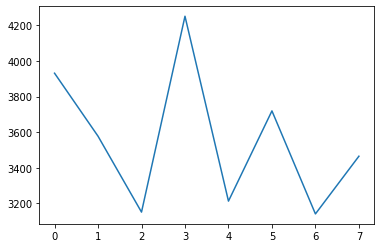

In [27]:
opt = get_opts()
model = CapsuleNetwork(opt)
if opt.use_cuda & torch.cuda.is_available():
    model.cuda()
#model.load_state_dict(torch.load('guide_model.pt'))
train_loader = loader.train_loader
valid_loader = loader.val_loader

train(opt, train_loader, valid_loader, model)


VALID loss: 3529.5438   Marginal loss: 0.4050   Reconstruction loss: 7058277.3068
Accuracy: 1038/1400 0.7414



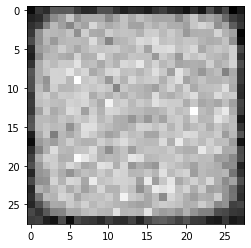

In [35]:
evaluate(opt, valid_loader, model, 'VALID', True)

## Training MNIST


In [46]:
def get_MNIST_dataloader(opt):
    # MNIST Dataset
    train_dataset = datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

    test_dataset = datasets.MNIST(root='./data/',
                                  train=False,
                                  transform=transforms.ToTensor())

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=opt.batch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=opt.batch_size,
                                              shuffle=True)

    return train_loader, test_loader

In [47]:
def train_MNIST(opt, train_loader, valid_loader, model):
    num_sample = len(train_loader.dataset)
    num_batches = len(train_loader)
    train_loss_list = []
    loss_val = 0.

    optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, opt.gamma)
    model.train()
    for epoch in range(opt.epochs):
    
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_size = data.size(0)
            target = torch.one_hot((batch_size, 10), target.view(-1, 1))
            assert target.size() == torch.Size([batch_size, opt.n_classes]), target.size()

            # Use GPU if available
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
            if opt.use_cuda & torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss, marginal_loss, reconstruction_loss = model.loss(output, data, target)
            loss_val = loss.item()

            loss.backward()
            optimizer.step()

        if epoch % 5 == 0: 
            train_loss_list.append(loss_val)
        if epoch % 2 == 0:
            print('Epoch: {}'.format(epoch))
            print('Learning rate: {:.2e}'.format(scheduler.get_last_lr()[0]))
            evaluate_MNIST(opt, train_loader, model, 'TRAIN', False) 
            evaluate_MNIST(opt, valid_loader, model, 'VALID', False) 
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'guide_model_mnist.pt')
        scheduler.step()
    fig = plt.figure()
    plt.plot([i for i in range(len(train_loss_list))], train_loss_list, '-')

In [48]:
def evaluate_MNIST(opt, valid_loader, model, type_data, plot=False):
    sum_loss = 0
    sum_marginal_loss = 0
    sum_reconstruction_loss = 0
    correct = 0
    num_sample = len(valid_loader.dataset)
    num_batch = len(valid_loader)

    model.eval()
    for data, target in valid_loader:
        batch_size = data.size(0)
        target = torch.one_hot((batch_size, 10), target.view(-1, 1))
        assert target.size() == torch.Size([batch_size, opt.n_classes])

        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        if opt.use_cuda & torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        output = model(data)  # (batch_size, n_classes, 16)
        loss, marginal_loss, reconstruction_loss = model.loss(output, data, target)
        sum_loss += loss.item()
        sum_marginal_loss += marginal_loss.item()
        sum_reconstruction_loss += reconstruction_loss.item()

        norms = torch.sqrt(torch.sum(output**2, dim=2))  # (batch_size, n_classes)
        pred = norms.data.max(1, keepdim=True)[1].type(torch.LongTensor)  # (batch_size, 1)
        label = target.max(1, keepdim=True)[1].type(torch.LongTensor)  # (batch_size, 1)
        correct += pred.eq(label.view_as(pred)).cpu().sum().item()

    if plot:
        recons = model.Decoder(output, target)
        recons = recons.view(batch_size, opt.image_size, opt.image_size)
        recons = recons[0].cpu()
        if (correct / float(num_sample)) > 0.703: plt.imshow(recons.detach(), cmap = "gray")

    sum_loss /= num_batch
    sum_marginal_loss /= num_batch
    sum_reconstruction_loss /= num_batch
    print('\n{} loss: {:.4f}   Marginal loss: {:.4f}   Reconstruction loss: {:.4f}'.format(
        type_data, sum_loss, sum_marginal_loss, sum_reconstruction_loss))
    print('Accuracy: {}/{} {:.4f}\n'.format(correct, num_sample,
        correct / num_sample))

In [49]:
def get_opts_MNIST():
    parser = argparse.ArgumentParser(description='CapsuleNetwork')
    parser.add_argument('-batch_size', type=int, default=32)
    parser.add_argument('-lr', type=float, default=1e-6)
    parser.add_argument('-epochs', type=int, default=20)
    parser.add_argument('-image_size', type=int, default=28)
    parser.add_argument('-n_classes', type=int, default=10)
    parser.add_argument('-use_cuda', default=True)
    parser.add_argument('-gamma', type=float, default=0.8)
    parser.add_argument('-r', type=int, default=3)
    opt, _ = parser.parse_known_args()
    return opt

In [ ]:
opt = get_opts_MNIST()
from torchvision import datasets, transforms

model = CapsuleNetwork(opt)
if opt.use_cuda & torch.cuda.is_available():
    model.cuda()

setattr(torch, 'one_hot', torch_extras.one_hot)
train_loader, valid_loader = get_MNIST_dataloader(opt)
train_MNIST(opt, train_loader, valid_loader, model)

/usr/local/lib/python3.7/dist-packages/torch_extras/extras.py:117: UserWarning: volatile was removed (Variable.volatile is always False)
  mask = Variable(mask, volatile=index.volatile)


In [ ]:
evaluate_MNIST(opt, valid_loader, model, 'VALID', True)